# Plot 1240K SNPs along the genome

In [7]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import shutil as shutil
import matplotlib.pyplot as plt

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

#sys.path.append("./package/")  # Since now we are in the Root Directory.
sys.path.insert(0,"./package/")  # Hack to get developer package
#from hmm_inference import HMM_Analyze   # Do not move. Should be after sys.path..

sys.path.append("./Notebooks/Mosaic1000G_Analysis/mosaic_test/")  # Assume we are in Hapsburg Root Directory
#from hmm_inference import HMM_Analyze   # Do not move. Should be after sys.path..

from load_funcs import Summary_ROH_Calls

midway2-0402.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


In [68]:
output_prefix = "merged/"   #"ROHin100/" #"ROHin50/" prefix_out = "e01rohin300/" diploidGT/
#mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/lambda_rc2.0/"
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"
bl_lens = [2, 4, 6, 8, 10]
bl_focus = 0 # To show background rate
ch=3
nr_iid=100

roh = Summary_ROH_Calls(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, 
                        blen_cm = bl_focus, output_prefix = output_prefix, output=1)
df_call_fp = roh.collect_fp_df()



In [69]:
### Load the Map Positions
def load_map(path_map = "./Simulated/1000G_Mosaic/TSI5/ch3_0cm/output/iid0/chr3/map.csv"):
    """Load and return Map Positions"""
    df_map = pd.read_csv(path_map, sep=",", header=None)  # Load the Meta File
    map_pos = df_map[0].values
    return map_pos

def prep_false_positive_blocks(df_call_fp, min_m=0.01, step=0.005):
    """Prepare False Positive Blocks.
    Returns bins and counts in there"""
    dft = df_call_fp[df_call_fp["lengthM"]>min_m]
    starts = dft["StartM"].values
    ends = dft["EndM"].values

    ### Create the Binned Statistic
    bins10 = np.arange(min(map_pos), max(map_pos), step=step)  # 0.1 cM Bins
    counts = np.zeros(len(bins10), dtype="int")

    for i in range(len(starts)):
        i1 = np.searchsorted(bins10, starts[i])
        i2 = np.searchsorted(bins10, ends[i])
        counts[i1:i2] = counts[i1:i2]+1 # Add one to the counter
    return bins10, counts

def plot_fp_chrom(bins10, counts=[], map_pos=[], ax=0, figsize=(12,6), 
                  ylim=[-0.1, 8] ,fs = 14, ylabel="Nr FP Blocks in 0.5 cM Bins", 
                  ylabel1="NR SNPs per 0.5 cM", xlabel="Map Position [Morgan], (Chromosome 3)",
                  c1 = "darkgray", c2 = "red", show=True):
    """Plot False Positive Rate along one Chromosome"""
    
    if ax==0:
        plt.figure(figsize=figsize)
        ax = plt.gca()
          
    ax.set_xlim((min(map_pos), max(map_pos)))
    
    if len(counts)>0:
        ax.plot(bins10, counts, color=c1)
        ax.tick_params(axis='y', labelcolor=c1)
        ax.set_ylim(ylim)
        ax.set_ylabel(ylabel, fontsize=fs, color=c1)

    ax1 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    n, b = np.histogram(map_pos, bins = bins10)
    x = (b[1:] + b[:-1]) / 2

    ax1.plot(x, n, color=c2, linewidth=1.0)
    ax1.tick_params(axis='y', labelcolor=c2)
    ax1.set_ylim([-1, 800])
    ax1.set_ylabel(ylabel1, color=c2, rotation=270, labelpad=fs*1.4, fontsize=fs)

    ax.set_xlabel(xlabel, fontsize=fs)
    if show:
        plt.show()

# Plot False Positives along Chromosome 3

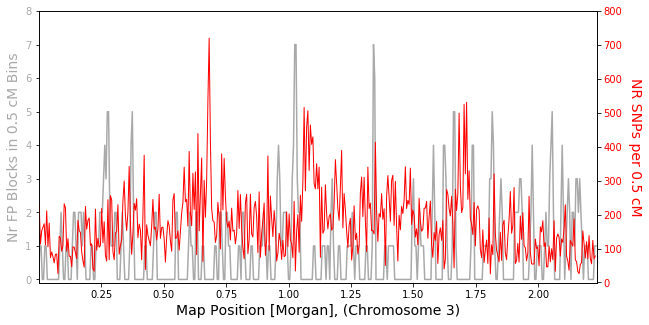

In [70]:
map_pos = load_map(path_map = "./Simulated/1000G_Mosaic/TSI5/ch3_0cm/output/iid0/chr3/map.csv")
bins10, counts = prep_false_positive_blocks(df_call_fp, min_m=0.01, step=0.005)
plot_fp_chrom(bins10, counts=counts, map_pos=map_pos, figsize=(10,5))